# Covid19 data analysis
This notebook uses the data pulled from the NHS England, google and apple APIs.

## Load useful libraries

In [16]:
import covid_data
import data_tools
import plot_tools
import ARIMA_tools
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Get the data
The data is automatically downloaded by a gitlab action once a week, and deposited into the "data" folder.

In [17]:
df_england_nhse_feed =  pd.read_csv("data/england_nhse_feed.csv")
df_uk_wide_nhse_feed = pd.read_csv("data/uk_nhse_feed.csv")
df_nhsregion_nhse_feed = pd.read_csv("data/nhsregion_nhse_feed.csv")
df_region_nhse_feed = pd.read_csv("data/region_nhse_feed.csv")
df_utla_nhse_feed = pd.read_csv("data/utla_nhse_feed.csv")
df_ltla_nhse_feed = pd.read_csv("data/ltla_nhse_feed.csv")

In [18]:
df_ltla_nhse_feed.query("~code.str.contains('[WSN]')")

,areatype,date,name,code,newCasesByPublishDate,cumCasesByPublishDate,cumCasesBySpecimenDateRate,newCasesBySpecimenDate,cumCasesBySpecimenDate,newDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDateRate,newDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDateRate
0,ltla,2020-03-16,Hartlepool,E06000001,NaN,NaN,1.1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ltla,2020-03-17,Hartlepool,E06000001,NaN,NaN,1.1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,ltla,2020-03-18,Hartlepool,E06000001,NaN,NaN,2.1,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ltla,2020-03-19,Hartlepool,E06000001,NaN,NaN,2.1,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ltla,2020-03-20,Hartlepool,E06000001,NaN,NaN,3.2,1.0,3.0,NaN,NaN,NaN,1.0,1.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166892,ltla,2021-08-14,Westminster,E09000033,97.0,NaN,7575.7,57.0,20443.0,0.0,310.0,114.9,0.0,310.0,114.9
166893,ltla,2021-08-15,Westminster,E09000033,79.0,NaN,7596.5,56.0,20499.0,0.0,310.0,114.9,1.0,311.0,115.3
166894,ltla,2021-08-16,Westminster,E09000033,60.0,NaN,7625.4,78.0,20577.0,1.0,311.0,115.3,0.0,311.0,115.3
166895,ltla,2021-08-17,Westminster,E09000033,80.0,NaN,7634.3,24.0,20601.0,0.0,311.0,115.3,0.0,311.0,115.3


In [19]:
df_lad_region_lkp = pd.read_csv('./shapefiles/Local_Authority_District_to_Region_(April_2021)_Lookup_in_England.csv')

In [20]:
df_lad_region_lkp

,FID,LAD21CD,LAD21NM,RGN21CD,RGN21NM
0,1,E06000001,Hartlepool,E12000001,North East
1,2,E06000011,East Riding of Yorkshire,E12000003,Yorkshire and The Humber
2,3,E06000002,Middlesbrough,E12000001,North East
3,4,E06000003,Redcar and Cleveland,E12000001,North East
4,5,E06000012,North East Lincolnshire,E12000003,Yorkshire and The Humber
...,...,...,...,...,...
304,305,E09000022,Lambeth,E12000007,London
305,306,E09000023,Lewisham,E12000007,London
306,307,E09000024,Merton,E12000007,London
307,308,E09000025,Newham,E12000007,London


In [21]:
df_ltla_nhse_feed = df_ltla_nhse_feed.merge(df_lad_region_lkp[['LAD21CD','RGN21CD','RGN21NM']], left_on='code', right_on='LAD21CD')

In [22]:
df_ltla_nhse_feed[df_ltla_nhse_feed.RGN21NM.str.contains('South West')]

,areatype,date,name,code,newCasesByPublishDate,cumCasesByPublishDate,cumCasesBySpecimenDateRate,newCasesBySpecimenDate,cumCasesBySpecimenDate,newDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDateRate,newDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDateRate,LAD21CD,RGN21CD,RGN21NM
11110,ltla,2020-03-11,Bath and North East Somerset,E06000022,NaN,NaN,0.5,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,E06000022,E12000009,South West
11111,ltla,2020-03-12,Bath and North East Somerset,E06000022,NaN,NaN,1.5,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,E06000022,E12000009,South West
11112,ltla,2020-03-13,Bath and North East Somerset,E06000022,NaN,NaN,2.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,E06000022,E12000009,South West
11113,ltla,2020-03-14,Bath and North East Somerset,E06000022,NaN,NaN,2.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,E06000022,E12000009,South West
11114,ltla,2020-03-15,Bath and North East Somerset,E06000022,NaN,NaN,2.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,E06000022,E12000009,South West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124797,ltla,2021-08-14,Somerset West and Taunton,E07000246,77.0,NaN,5403.4,62.0,8398.0,0.0,197.0,126.8,0.0,197.0,126.8,E07000246,E12000009,South West
124798,ltla,2021-08-15,Somerset West and Taunton,E07000246,51.0,NaN,5436.8,52.0,8450.0,0.0,197.0,126.8,0.0,197.0,126.8,E07000246,E12000009,South West
124799,ltla,2021-08-16,Somerset West and Taunton,E07000246,59.0,NaN,5507.0,109.0,8559.0,0.0,197.0,126.8,0.0,197.0,126.8,E07000246,E12000009,South West
124800,ltla,2021-08-17,Somerset West and Taunton,E07000246,37.0,NaN,5519.8,20.0,8579.0,0.0,197.0,126.8,0.0,197.0,126.8,E07000246,E12000009,South West


In [23]:
df_local_auth_shapes = gpd.read_file('./shapefiles/Local_Authority_Districts_(December_2020)_UK_BGC.geojson').set_index('LAD20CD')

In [24]:
df_local_auth_shapes[df_local_auth_shapes.LAD20NM.str.contains('Lanc')]

,OBJECTID,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,geometry
LAD20CD,,,,,,,,,,
E07000121,141,Lancaster,,356896,464988,-2.66030,54.079010,5.667526e+08,324778.496159,"MULTIPOLYGON (((-2.45959 54.23957, -2.45878 54..."
E07000127,147,West Lancashire,,342611,413270,-2.86893,53.612831,3.465020e+08,215694.124533,"MULTIPOLYGON (((-2.86290 53.73336, -2.86381 53..."


In [25]:
df_south_west_ltla_nhse_feed = df_ltla_nhse_feed[df_ltla_nhse_feed.RGN21NM.str.contains('(South)')]
max_date = df_south_west_ltla_nhse_feed['date'].max()

df_local_auth_shapes_ltla_feed = df_local_auth_shapes.merge(df_south_west_ltla_nhse_feed#[['code','date','newCasesByPublishDate']]
                                                            , left_index=True ,right_on='code')

D:\Anaconda3\envs\covid19_analysis\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


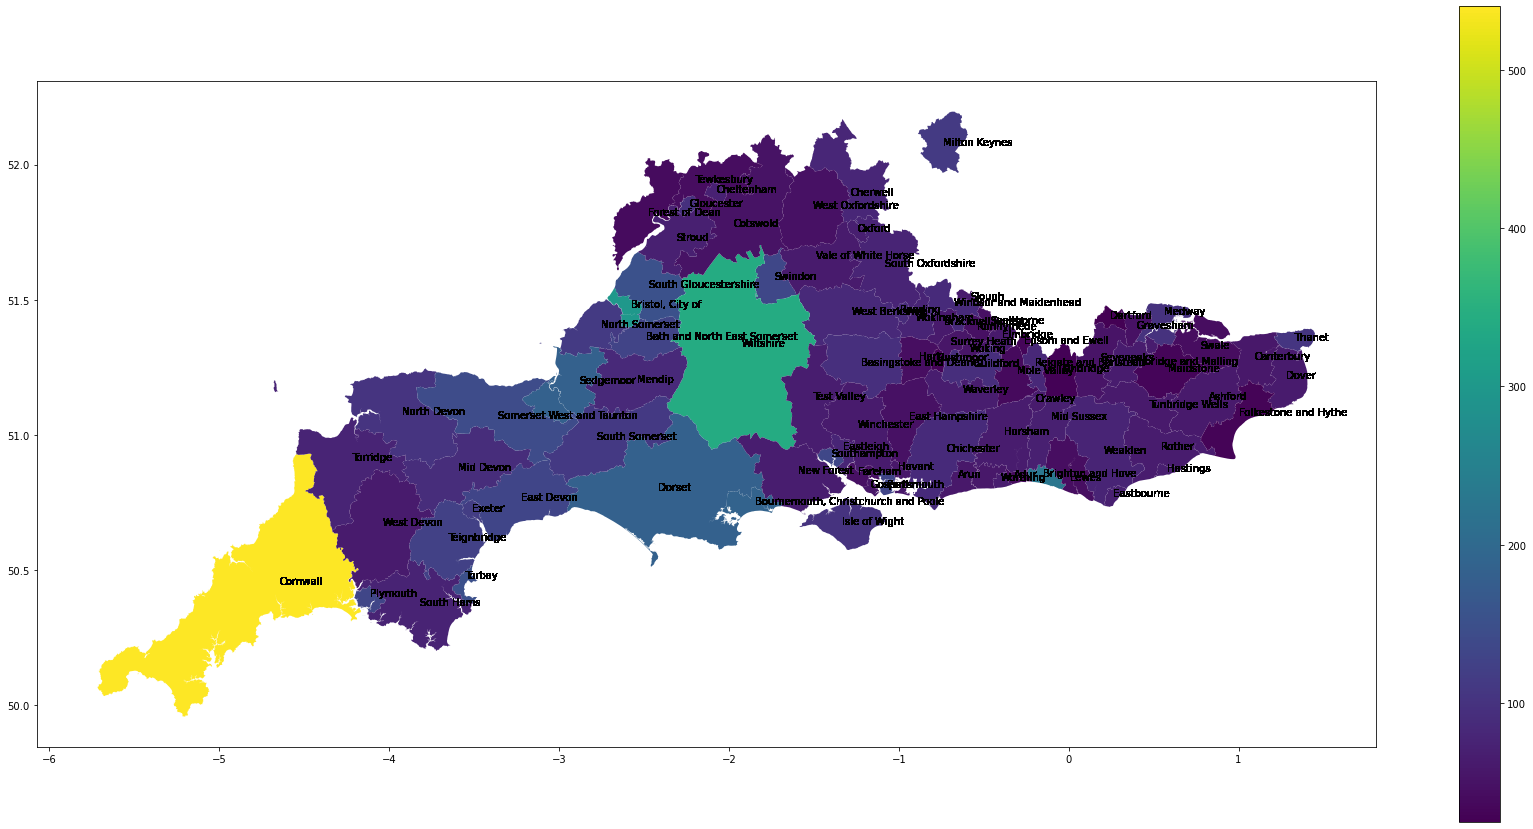

In [26]:
# get the most recent days worth of data.
fig, ax = plt.subplots(figsize=(30,15))
df_local_auth_shapes_ltla_feed.query(f"date == '{max_date}'").plot(column = 'newCasesByPublishDate', legend=True, ax=ax)
for idx, ltla_row in df_local_auth_shapes_ltla_feed.iterrows():
    ax.annotate(ltla_row['LAD20NM'], (ltla_row['LONG'], ltla_row['LAT']))